Mounted at /content/drive
Mounted at /content/gdrive
70 30


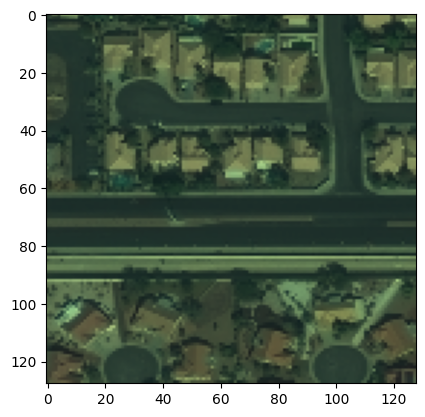

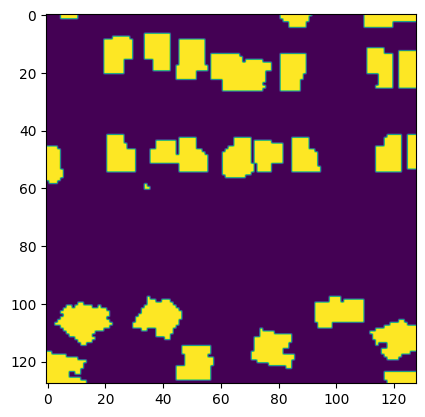

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization[0][0

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/gdrive")

# Set working directory
import os
os.chdir(r'/content/gdrive/MyDrive/building')

# Load and sort image paths
train_x = sorted(glob.glob('train/*_image.tif'))
train_y = sorted(glob.glob('train/*_label.tif'))
test_x = sorted(glob.glob('test/*_image.tif'))
test_y = sorted(glob.glob('test/*_label.tif'))

print(len(train_x), len(test_x))

# Convert training images to numpy arrays
train_xx = np.zeros((70, 128, 128, 3))
train_yy = np.zeros((70, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):
    img = Image.open(img)
    np_img = np.array(img)
    train_xx[i] = np_img

    mask = Image.open(mask)
    np_mask = np.array(mask).reshape(128, 128, 1)
    train_yy[i] = np_mask

# Convert test images to numpy arrays
test_xx = np.zeros((30, 128, 128, 3))
test_yy = np.zeros((30, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_x, test_y)):
    img = Image.open(img)
    np_img = np.array(img)
    test_xx[i] = np_img

    mask = Image.open(mask)
    np_mask = np.array(mask).reshape(128, 128, 1)
    test_yy[i] = np_mask

# Plot sample images
plt.imshow(train_xx[20, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[20, :, :, 0].astype('uint8'))
plt.show()

# Save numpy arrays
np.save('train_xx.npy', train_xx)
np.save('train_yy.npy', train_yy)
np.save("test_xx.npy", test_xx)
np.save("test_yy.npy", test_yy)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Enhanced SegNet Model with Regularization
def build_deep_segnet(input_shape=(128, 128, 3), num_classes=1):
    inputs = Input(shape=input_shape)

    def conv_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
        x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def encoder_block(x, filters):
        x = conv_block(x, filters)
        x = conv_block(x, filters)
        p = MaxPooling2D((2, 2), (2, 2))(x)
        return x, p

    def decoder_block(x, filters, skip):
        x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(x)
        x = Concatenate()([x, skip])
        x = conv_block(x, filters)
        x = conv_block(x, filters)
        return x

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)
    b1 = conv_block(b1, 1024)

    d1 = decoder_block(b1, 512, s4)
    d2 = decoder_block(d1, 256, s3)
    d3 = decoder_block(d2, 128, s2)
    d4 = decoder_block(d3, 64, s1)

    outputs = Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(d4)

    model = Model(inputs, outputs)
    return model

model = build_deep_segnet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model with data augmentation
train_generator = datagen.flow(train_xx, train_yy, batch_size=10)

history = model.fit(train_generator, validation_data=(test_xx, test_yy), epochs=100, verbose=1,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

# Plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predict and evaluate
threshold = 0.5
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)

# Compare random predicted and actual y values
plt.imshow(pred_test[10, :, :, 0])
plt.show()
plt.imshow(test_yy[10, :, :, 0])
plt.show()

# Convert numpy array to images
def convert_numpy_array_to_img(in_npy, out_folder, channel=3):
    n = in_npy.shape[0]
    for i in range(n):
        if channel == 3:
            image = Image.fromarray(in_npy[i].astype('uint8'))
            image.save(os.path.join(out_folder, f"{i}_image.tif"))
        else:
            image = Image.fromarray(in_npy[i, :, :, 0])
            image.save(os.path.join(out_folder, f"{i}_label.tif"))

# Save images
convert_numpy_array_to_img(train_xx, 'train')
convert_numpy_array_to_img(train_yy, 'train', channel=1)
convert_numpy_array_to_img(test_xx, 'test')
convert_numpy_array_to_img(test_yy, 'test', channel=1)
